# IMPORT LIBRARIES

In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import matplotlib.pyplot as plt

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

## Cryptocurrency List

In [2]:
dfCrpytocurrencies = pd.read_excel('Static Data\crpytocurrencies.xlsx')
dfCrpytocurrencies.head()

,Symbol
0,BTCUSD
1,ETHUSD
2,BCHUSD
3,LTCUSD
4,RPLUSD


## MetaTrader 5

In [3]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 9, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2022, 3, 10, tzinfo=gc_o_TIME_ZONE)

In [4]:
def aFetchFromMT5(sSymbol,dtFrom, dtTo, oFreq):
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    aOhlcSample = mt5.copy_rates_range(
        sSymbol,
        oFreq,
        dtFrom, 
        dtTo
    )

    if len(aOhlcSample) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()
    return aOhlcSample

In [5]:
sOutputSymbol = "BTCUSD"
aInputSymbols = dfCrpytocurrencies['Symbol'].values

aSymbolsToFetch = np.append(aInputSymbols, sOutputSymbol)
aSymbolsToFetch = np.unique(aSymbolsToFetch)

In [6]:
dfOhlcSource = pd.read_csv('dfOhlcSource.csv')
dfOhlcSource['timestamp'] = pd.DatetimeIndex(dfOhlcSource['timestamp'])
dfOhlcSource.set_index('timestamp', inplace=True)

# PREPROCESSING

In [7]:
sModelName = os.path.join(sOutputSymbol , "__deep learning model__")

## Add Seasonal Features

In [8]:
dfOhlcSource["weekday"] = dfOhlcSource.index.weekday
dfOhlcSource["hour"] = dfOhlcSource.index.hour
dfOhlcSource["minute"] = dfOhlcSource.index.minute

## Add Return Feature

In [9]:
dfOhlcSource["return"] = (dfOhlcSource["close"] - dfOhlcSource["open"])/dfOhlcSource["open"]

## Add Candle Features

In [10]:
dfOhlcSource["upper_shadow"] =( dfOhlcSource["high"] - dfOhlcSource[['close', 'open']].max(axis=1))/ dfOhlcSource[['close', 'open']].max(axis=1)
dfOhlcSource["lower_shadow"] = (dfOhlcSource[['close', 'open']].min(axis=1) - dfOhlcSource["low"])/dfOhlcSource["low"]

## Transform Symbols to Columns

In [11]:
dfOhlc = pd.DataFrame()

i = 1
for sSymbol in aSymbolsToFetch:
    dfSymbolValues = dfOhlcSource[dfOhlcSource['symbol'] == sSymbol]

    if i == 1:
        sHow = "right"
    else:
        sHow = "inner"
    
    dfSymbolValues = dfSymbolValues.drop('symbol', axis = 1)
    
    dfOhlc = dfOhlc.join(dfSymbolValues,how = sHow, rsuffix=sSymbol)
    
    i = i + 1
    
aColumnsOhlc = list()
for sSymbol in aSymbolsToFetch:
    for sColumn in dfOhlcSource.columns:
        if sColumn != 'symbol':
            sNewColumn = sSymbol + ";" + sColumn
            aColumnsOhlc.append(sNewColumn)
    
dfOhlc.columns = aColumnsOhlc

dfOhlc.head()

,BCHUSD;open,BCHUSD;high,BCHUSD;low,BCHUSD;close,BCHUSD;tick_volume,BCHUSD;spread,BCHUSD;real_volume,BCHUSD;weekday,BCHUSD;hour,BCHUSD;minute,...,RPLUSD;tick_volume,RPLUSD;spread,RPLUSD;real_volume,RPLUSD;weekday,RPLUSD;hour,RPLUSD;minute,RPLUSD;return,RPLUSD;upper_shadow,RPLUSD;lower_shadow,RPLUSD;body
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,618.16,633.29,618.16,630.75,768,405,0,2,0,0,...,597,30,0,2,0,0,0.005549,0.006028,0.001453,0.0065
2021-09-01 00:30:00,630.74,634.04,629.43,629.66,899,405,0,2,0,30,...,1356,36,0,2,0,30,-0.000509,0.010527,0.001446,0.0006
2021-09-01 01:00:00,629.62,631.06,626.84,628.04,1252,405,0,2,1,0,...,1434,31,0,2,1,0,-0.017413,0.002633,0.008544,0.0205
2021-09-01 01:30:00,628.04,632.47,626.38,632.33,1446,405,0,2,1,30,...,1365,30,0,2,1,30,0.012621,0.001451,0.004254,0.0146
2021-09-01 02:00:00,632.38,634.64,630.44,634.34,1542,405,0,2,2,0,...,1422,30,0,2,2,0,0.004183,0.002890,0.007829,0.0049


## Split Data

In [12]:
fTrainingRatio = 0.7
fValidationRatio = 0.15
fTestRatio = 0.15

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest = train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

In [13]:
# sns.lineplot(data = dfScaledOhlc.loc[ixTrain, sOutputSymbol + ';return'], color = 'green', legend = True)
# sns.lineplot(data = dfScaledOhlc.loc[ixValidation,sOutputSymbol + ';return'], color = 'yellow', legend = True)
# sns.lineplot(data = dfScaledOhlc.loc[ixTest, sOutputSymbol + ';return'], color = 'red', legend = True)

In [14]:
# sns.histplot(data = dfScaledOhlc.loc[ixTrain,sOutputSymbol + ';return'], color = 'green', legend = True)
# sns.histplot(data = dfScaledOhlc.loc[ixValidation, sOutputSymbol + ';return'], color = 'yellow', legend = True)
# sns.histplot(data = dfScaledOhlc.loc[ixTest,sOutputSymbol + ';return'], color = 'red', legend = True)

## Anomaly Detection

In [15]:
# oLocalOutlierFactor =  LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# sFeatureToDetectAnomaly = 'BRENT;spread'
# dfAnomalyDetection =  dfOhlc.loc[:, [sFeatureToDetectAnomaly]]
# dfAnomalyDetection.loc[:, 'anomaly'] = oLocalOutlierFactor.fit_predict(dfAnomalyDetection) 

# # visualization
# fig, ax = plt.subplots(figsize=(10,6))

# dfAnomaly = dfAnomalyDetection.loc[dfAnomalyDetection['anomaly'] == -1]

# ax.plot(dfAnomalyDetection.index, dfAnomalyDetection[sFeatureToDetectAnomaly], color='blue', label = 'Normal')
# ax.scatter(dfAnomaly.index,dfAnomaly[sFeatureToDetectAnomaly], color='red', label = 'Anomaly')
# plt.legend()
# plt.show();

In [16]:
# aFeaturesToDetectAnomaly = ['upper_shadow', 'lower_shadow','body' ,'return']
# aFeaturesToDetectAnomaly = list(map(";".join, itertools.product(aInputSymbols, aFeaturesToDetectAnomaly)))

# dfAnomalies = pd.DataFrame(index = dfOhlc.index, columns = aFeaturesToDetectAnomaly)
# for sCol in dfOhlc.columns:
#     oIsolationForest =  IsolationForest(contamination=0.05, random_state=0)
#     dfAnomalies.loc[:, sCol] = oIsolationForest.fit_predict(dfOhlc.loc[:, [sCol]].values) 
    
    

# # visualization
# # fig, ax = plt.subplots(figsize=(10,6))

# # dfAnomaly = dfAnomalyDetection.loc[dfAnomalyDetection['anomaly'] == -1]

# # ax.plot(dfAnomalyDetection.index, dfAnomalyDetection[sFeatureToDetectAnomaly], color='blue', label = 'Normal')
# # ax.scatter(dfAnomaly.index,dfAnomaly[sFeatureToDetectAnomaly], color='red', label = 'Anomaly')
# # plt.legend()
# # plt.show();

In [17]:
# # dfNonOutlier = dfOhlc.loc[
# #     ixTrain.append(ixValidation).drop(
# #         dfAnomalyDetection[dfAnomalyDetection['anomaly'] == -1].index
# # ), sFeatureToDetectAnomaly].to_frame()

# # sns.lineplot(data = dfNonOutlier)

# ixToDrop = dfAnomalyDetection[dfAnomalyDetection['anomaly'] == -1].index
# ixTrain = ixTrain.drop(ixToDrop, errors='ignore' )
# ixValidation = ixValidation.drop(ixToDrop, errors='ignore')

In [18]:
# plt.subplots(figsize=(10,6))
# sns.lineplot(data = dfAnomalyDetection.loc[ixTrain.append(ixValidation), sFeatureToDetectAnomaly])

## Scale Data

In [19]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)

for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain.append(dfValidation))
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Input Dataset

In [20]:
aInputFeatures = ['upper_shadow', 'lower_shadow' ,'return']
aInputFeatures = list(map(";".join, itertools.product(aInputSymbols, aInputFeatures)))

iNrInputFeatures = len(aInputFeatures)

iBackwardTimeWindow = 8
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

aTplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
aIxInputColumns = pd.MultiIndex.from_tuples(aTplInputColumns, names= ['time_step', 'feature'])

dfInput = pd.DataFrame(columns = aIxInputColumns)

for tplColumn in list(dfInput.columns):
    dfInput.loc[:, tplColumn] = dfScaledOhlc[(tplColumn[1])].shift(-tplColumn[0])

    
ixNas = dfInput[dfInput.isna().any(axis=1)].index
dfInput.drop(ixNas, inplace = True, errors = 'ignore') 
ixTrain= ixTrain.drop(ixNas, errors = 'ignore') 
ixValidation= ixValidation.drop(ixNas,   errors = 'ignore') 
ixTest = ixTest.drop(ixNas,   errors = 'ignore') 

dfInput.head()

time_step                            -8                                    \
feature             BTCUSD;upper_shadow BTCUSD;lower_shadow BTCUSD;return   
timestamp                                                                   
2021-09-01 04:00:00            0.272382           -0.344248      0.367626   
2021-09-01 04:30:00            1.482079           -0.838114     -0.274886   
2021-09-01 05:00:00             0.09279           -0.050609     -0.230078   
2021-09-01 05:30:00           -0.792066           -0.003061      0.948749   
2021-09-01 06:00:00           -0.402557           -0.069069      0.438649   

time_step                                                                  \
feature             ETHUSD;upper_shadow ETHUSD;lower_shadow ETHUSD;return   
timestamp                                                                   
2021-09-01 04:00:00            0.101196           -0.454084      1.424233   
2021-09-01 04:30:00            2.108089           -0.775831     -0.517132   
2021-09-01 05:00:00              0.5739            0.317816     -0.619927   
2021-09-01 05:30:00           -0.693713            0.527347      1.228276   
2021-09-01 06:00:00           -0.541873            0.264807      0.530848   

time_step                                                                  \
feature             BCHUSD;upper_shadow BCHUSD;lower_shadow BCHUSD;return   
timestamp                                                                   
2021-09-01 04:00:00            0.774056           -0.871024      2.653804   
2021-09-01 04:30:00            1.295853           -0.762139     -0.288865   
2021-09-01 05:00:00             0.02065            -0.30058     -0.395111   
2021-09-01 05:30:00           -0.873851            -0.08133      0.849736   
2021-09-01 06:00:00           -0.764932            0.045928      0.352426   

time_step                                ...            -1  \
feature             LTCUSD;upper_shadow  ... ETHUSD;return   
timestamp                                ...                 
2021-09-01 04:00:00            0.719274  ...     -1.579631   
2021-09-01 04:30:00            1.389041  ...      0.311729   
2021-09-01 05:00:00            0.247703  ...      0.848298   
2021-09-01 05:30:00           -0.676376  ...      0.724019   
2021-09-01 06:00:00           -0.849824  ...     -0.867895   

time_step                                                                  \
feature             BCHUSD;upper_shadow BCHUSD;lower_shadow BCHUSD;return   
timestamp                                                                   
2021-09-01 04:00:00           -0.764011           -0.851954     -1.417708   
2021-09-01 04:30:00           -0.589773           -0.135068      0.314612   
2021-09-01 05:00:00           -0.776984            0.269477      0.415617   
2021-09-01 05:30:00            -0.90098            0.470783       0.11731   
2021-09-01 06:00:00           -0.083458           -0.539534      0.013394   

time_step                                                                  \
feature             LTCUSD;upper_shadow LTCUSD;lower_shadow LTCUSD;return   
timestamp                                                                   
2021-09-01 04:00:00            -0.84953           -0.301025      -0.95781   
2021-09-01 04:30:00           -0.597665            0.115612      0.283424   
2021-09-01 05:00:00            0.283195            0.252142      0.787553   
2021-09-01 05:30:00           -0.565569            0.300058      1.185322   
2021-09-01 06:00:00           -0.413653           -0.019622       -0.7982   

time_step                                                                  
feature             RPLUSD;upper_shadow RPLUSD;lower_shadow RPLUSD;return  
timestamp                                                                  
2021-09-01 04:00:00           -0.825667           -0.338218     -2.538037  
2021-09-01 04:30:00            -0.51259             0.08902      0.969554  
2021-09-01 05:00:00            0.16908

## Seasonal Decomposition

In [21]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# oResultSeasonalDecompose = seasonal_decompose(x = dfOhlc['MRO.N;close'], model='additive', period = 40)
# plt.figure(figsize=(10,8))
# oResultSeasonalDecompose.plot()
# plt.show()

## Independent Component Analysis

## Principal Component Analysis

* PCA is effected by scale so you need to scale the features in your data before applying PCA.

In [22]:
# from sklearn.decomposition import PCA
# iNrOfComponents = 3
# aPCAColumnNames = ['PCA1', 'PCA2', 'PCA3']
# oPca = PCA(n_components=iNrOfComponents)
# aPca = oPca.fit_transform(dfInput)
# dfPca = pd.DataFrame(data = aPca, columns = aPCAColumnNames, index = dfInput.index)

## Cluster Analysis

### Elbow Method

In [23]:
# from sklearn.cluster import KMeans

# aClusterCandidates = list(range(2, 20))
# aInertias = []
# for k in aClusterCandidates:
#     oKMeans = KMeans(n_clusters=k, random_state=0)
#     oKMeans.fit(dfPca)
#     aInertias.append(oKMeans.inertia_)

# plt.figure(figsize=(10,8))
# sns.lineplot(y = aInertias, x = aClusterCandidates,  marker = '^')

### Optimum Number of Clusters = 7

In [24]:
# iNrOfClusters = 3
# oKMeans = KMeans(n_clusters=iNrOfClusters, random_state=0)
# oKMeans.fit(dfPca.loc[ixTrain.append(ixValidation)])
# aClusters = oKMeans.predict(dfPca)
# dfPca['Cluster'] = aClusters

In [25]:
# from mpl_toolkits.mplot3d import Axes3D
# sns.set(style = "darkgrid")

# fig = plt.figure(figsize=(10,8))

# ax = fig.add_subplot(111, projection = '3d')

# for i in range(0,iNrOfClusters):
#     ixCluster = dfPca[dfPca['Cluster'] == i].index
#     ax.scatter(dfPca.loc[ixCluster, 'PCA1'], dfPca.loc[ixCluster, 'PCA2'], dfPca.loc[ixCluster, 'PCA3'])


# plt.show()

In [26]:
# dfInput = dfInput.loc[dfPca[dfPca['Cluster']==1].index]

## Output Dataset

In [27]:
aOutputFeatures = ['return']
aOutputFeatures = list(map(";".join, itertools.product([sOutputSymbol], aOutputFeatures)))
iNrOutputFeatures = len(aOutputFeatures)

iForwardTimeWindow = 4
aForwardTimeSteps = range(0, iForwardTimeWindow)


aTplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
aIxOutputColumns = pd.MultiIndex.from_tuples(aTplOutputColumns, names= ['time_step', 'feature'])

dfOutput = pd.DataFrame(columns = aIxOutputColumns)

for tplColumn in list(dfOutput.columns):
    dfOutput.loc[:, tplColumn] = dfOhlc[(tplColumn[1])].shift(-tplColumn[0])

ixNas = dfOutput[dfOutput.isna().any(axis=1)].index
dfOutput.drop(ixNas, inplace = True, errors = 'ignore') 
ixTrain= ixTrain.drop(ixNas, errors = 'ignore') 
ixValidation= ixValidation.drop(ixNas,   errors = 'ignore') 
ixTest = ixTest.drop(ixNas,   errors = 'ignore') 
dfOutput.head()

time_step,0,1,2,3
feature,BTCUSD;return,BTCUSD;return,BTCUSD;return,BTCUSD;return
timestamp,,,,
2021-09-01 00:00:00,0.001941,-0.001465,-0.001227,0.005021
2021-09-01 00:30:00,-0.001465,-0.001227,0.005021,0.002318
2021-09-01 01:00:00,-0.001227,0.005021,0.002318,-0.002022
2021-09-01 01:30:00,0.005021,0.002318,-0.002022,-0.001229
2021-09-01 02:00:00,0.002318,-0.002022,-0.001229,-0.006108


In [28]:
axMerged = dfInput.index.join(dfOutput.index, how = 'inner')

dfInput = dfInput.loc[axMerged]
dfOutput = dfOutput.loc[axMerged]

ixTrain = ixTrain.join(axMerged, how = "inner")
ixValidation = ixValidation.join(axMerged, how = "inner")
ixTest = ixTest.join(axMerged, how = "inner")

In [29]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [30]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

### Pixel Conversion

In [31]:
# iNrOfBins = 28
# ixZScoreIntervals = pd.interval_range(-3, 3 , iNrOfBins)

# def aConvertToPixels(aNormalizedData):
#     #(sample size, feature size, Nr of Bins, time step)
#     aConvertedData = np.zeros((aNormalizedData.shape[0] ,   aNormalizedData.shape[2] , iNrOfBins  , aNormalizedData.shape[1]))

#     for iI,  aI in enumerate(aNormalizedData): #samples
#         for iJ, aJ in enumerate(aI): #time steps
#             for iK, fK in enumerate(aJ): #features
#                 if fK > 0 and fK >= ixZScoreIntervals[-1].right:
#                     aConvertedData[iI][iJ][-1] == 1   
#                 elif fK < 0 and fK <= ixZScoreIntervals[0].left:
#                     aConvertedData[iI][iJ][0] == 1   
#                 else:
#                     iFoundIndex = ixZScoreIntervals.get_loc(fK)
#                     aConvertedData[iI][iK][iFoundIndex][iJ] = 1
    
#     return aConvertedData


# def aConvertFromPixels(aPixelData):
#     aConvertedData = np.zeros((aPixelData.shape[0] ,  aPixelData.shape[3], aPixelData.shape[1]))

#     for iI,  aI in enumerate(aPixelData): #samples
#             for iJ, aJ in enumerate(aI): #features
#                 aJ = np.transpose(aJ)
#                 for iK, aK in enumerate(aJ): #time steps
#                     iMaxIndex = np.argmax(aK)
#                     fCenterOfBin = ixZScoreIntervals[iMaxIndex].mid
#                     aConvertedData[iI][iK][iJ] = fCenterOfBin

#     return aConvertedData
    

# aPixelOutputTrain = aConvertToPixels(aOutputTrain)
# aPixelOutputValidation = aConvertToPixels(aOutputValidation)
# aPixelOutputTest  = aConvertToPixels(aOutputTest)
# aPixelInputTrain = aConvertToPixels(aInputTrain)
# aPixelInputValidation = aConvertToPixels(aInputValidation)
# aPixelInputTest = aConvertToPixels(aInputTest)

#  MODEL DEVELOPMENT

## Set Hyperparameters

In [32]:
iBatchSize = 64
iEpochSize = 10000
iNrOfHiddenNeurons = 32

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

## Define Loss Function

In [33]:
def fCalculateLoss(aActual, aPrediction):
    aDeltaActual = tf.subtract(aActual[:,1:], aActual[:,:-1])    
    aDeltaPrediction = tf.subtract(aPrediction[:,1:], aPrediction[:,:-1])

    aDeltaPerTimeSteps = tf.abs(aDeltaActual - aDeltaPrediction)
    
    aSignsActual = tf.sign(aDeltaActual)
    aSignsPrediction = tf.sign(aDeltaPrediction)
    aDeltaSigns = tf.abs(aSignsActual - aSignsPrediction)

    aLossPerTimeSteps = aDeltaPerTimeSteps * aDeltaSigns
    
    fLoss = tf.math.reduce_mean(aLossPerTimeSteps)
    
    if fLoss == 0:
        fLoss = tf.keras.metrics.mean_absolute_error(aActual, aPrediction)

    return fLoss

## Build Model

### LSTM

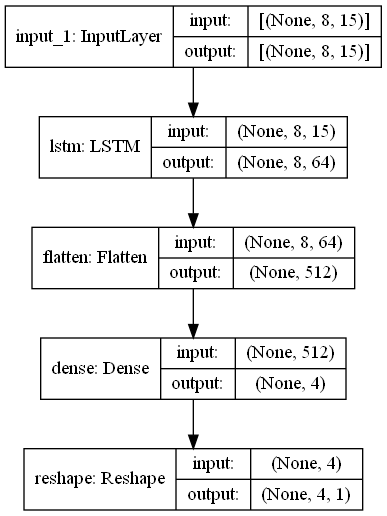

In [34]:
aInputDeepLstm = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures))

aW = keras.layers.LSTM(64, return_sequences = True)(aInputDeepLstm)
aW = keras.layers.Flatten()(aW)
aW = keras.layers.Dense(iForwardTimeWindow*iNrOutputFeatures)(aW)
aW = keras.layers.Reshape((iForwardTimeWindow, iNrOutputFeatures))(aW)

aOutputDeepLstm = aW
oModelDeepLstm = keras.Model(
    inputs=aInputDeepLstm,
    outputs=aOutputDeepLstm
)

oOptimizerDeepLstm = tf.keras.optimizers.Adam(learning_rate=1e-04)
oModelDeepLstm.compile(optimizer=oOptimizerDeepLstm,
                         loss = fCalculateLoss
                        )

oPredictiveModel = oModelDeepLstm

tf.keras.utils.plot_model(oModelDeepLstm,  show_shapes=True)

### Deep CNN

In [35]:
# aInputDeepCnn = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aW = keras.layers.LSTM(64, return_sequences = True)(aInputDeepCnn)
# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures * iNrOfBins, iForwardTimeWindow, 1))(aW)
# aW = keras.layers.Conv2D(64, (4,4), (1,1), padding = "same" )(aW)
# aW = keras.layers.MaxPool2D(pool_size = (4, 4))(aW)
# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

# aOutputDeepCnn = aW
# oModelDeepCnn = keras.Model(
#     inputs=aInputDeepCnn,
#     outputs=aOutputDeepCnn
# )

# oOptimizerDeepCnn = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelDeepCnn.compile(optimizer=oOptimizerDeepCnn,
#                          loss = fCalculateLoss
#                         )

# tf.keras.utils.plot_model(oModelDeepCnn,  show_shapes=True)

#### Deep Convolutional Generative Adversarial Network Model

##### Generator Model

In [36]:
# aInputGenerator = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aW = keras.layers.Flatten()(aInputGenerator)
# aW = keras.layers.Dense(iNrOutputFeatures*iNrOfBins*iForwardTimeWindow, use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Reshape((iNrOutputFeatures*iNrOfBins, iForwardTimeWindow, 1))(aW)

# aW = keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(aW)

# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOutputFeatures*iNrOfBins*iForwardTimeWindow, use_bias=False)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

# aOutputGenerator = aW
# oModelGenerator = keras.Model(inputs = aInputGenerator, 
#                               outputs = aOutputGenerator)

# def fCalculateGeneratorLoss(aFakeOutput):
#     oCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#     fTotalLoss = oCrossEntropy(tf.ones_like(aFakeOutput), aFakeOutput)
#     return fTotalLoss

# oOptimizerGenerator = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelGenerator.compile(optimizer=oOptimizerGenerator,
#                          loss = fCalculateGeneratorLoss
#                         )

# tf.keras.utils.plot_model(oModelGenerator,  show_shapes=True)

##### Discriminator Model

In [37]:
# aInputDiscrimantor= keras.Input(
#     shape=(iNrOutputFeatures, iNrOfBins, iForwardTimeWindow),
#     name = "aInputDiscrimantor")


# aW = keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(aInputDiscrimantor)
# aW = keras.layers.LeakyReLU()(aW)
# aW = keras.layers.Dropout(0.3)(aW)

# aW = keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(aW)
# aW = keras.layers.LeakyReLU()(aW)
# aW = keras.layers.Dropout(0.3)(aW)

# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(1)(aW)

# def fCalculateDiscrimantorLoss(aRealOutput, aFakeOutput):
#     oCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#     fRealLoss = oCrossEntropy(tf.ones_like(aRealOutput), aRealOutput)
#     fFakeLoss = oCrossEntropy(tf.zeros_like(aFakeOutput), aFakeOutput)
#     fTotalLoss = fRealLoss + fFakeLoss
#     return fTotalLoss

# aOutputDiscriminator = aW
# oModelDiscriminator = keras.Model(
#     inputs=aInputDiscrimantor,
#     outputs=aOutputDiscriminator
# )

# oOptimizerDiscriminator = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelDiscriminator.compile(optimizer=oOptimizerDiscriminator,
#                          loss = fCalculateDiscrimantorLoss
#                            )

# tf.keras.utils.plot_model(oModelDiscriminator,  show_shapes=True)

##### GAN Model

In [38]:
# @tf.function
# def trainStep(aOutputActual):
#     aNoiseInput = tf.random.normal([iBatchSize, iBackwardTimeWindow, iNrInputFeatures])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         aOutputGenerated = oModelGenerator(aNoiseInput, training=True)
#         aFake = oModelDiscriminator(aOutputGenerated, training=True)
        
#         aReal = oModelDiscriminator(aOutputActual, training=True)
        
#         fLossGenerator = fCalculateGeneratorLoss(aFake)
#         fLossDiscriminator = fCalculateDiscrimantorLoss(aReal, aFake)

#     aGradientsGenerator = gen_tape.gradient(fLossGenerator, oModelGenerator.trainable_variables)
#     aGradientsDiscriminator = disc_tape.gradient(fLossDiscriminator, oModelDiscriminator.trainable_variables)

#     oOptimizerGenerator.apply_gradients(zip(aGradientsGenerator, oModelGenerator.trainable_variables))
#     oOptimizerDiscriminator.apply_gradients(zip(aGradientsDiscriminator, oModelDiscriminator.trainable_variables))
    
    

# for iEpoch in range(iEpochSize):
#     dtStart = time.time()

#     dsOutputTrain = tf.data.Dataset.from_tensor_slices(aPixelOutputTrain).batch(iBatchSize)
#     for aOutputTrain in dsOutputTrain:
#         trainStep(aOutputTrain)

#     print ('Time for epoch {} is {} sec'.format(iEpoch + 1, time.time()-dtStart))

### Convolutional Encoder-Decoder Model

### Luong's Attention Model

In [39]:
# aEncoderInputs = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))


# aEncoderHiddens, aFinalH, aFinalC = keras.layers.LSTM(iNrOfHiddenNeurons,
#                                          return_state = True, 
#                                          return_sequences = True
#                                         )(aEncoderInputs)
# aFinalH = keras.layers.BatchNormalization()(aFinalH)
# aFinalC = keras.layers.BatchNormalization()(aFinalC)

# aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFinalH)

# aDecoderHiddens = keras.layers.LSTM(iNrOfHiddenNeurons, 
#                        return_state = False, 
#                        return_sequences = True
#                       )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

# aAttentions = keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
# aAttentions = keras.layers.Activation('softmax')(aAttentions)

# aContextVector = keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
# aContextVector = keras.layers.BatchNormalization()(aContextVector)
# aContextVector = keras.layers.concatenate([aContextVector, aDecoderHiddens])

# aDecoderOutputs = keras.layers.TimeDistributed(
#     Dense(iNrOutputFeatures)
# )(aContextVector)

# oPredictiveModel = keras.Model(
#     inputs=aEncoderInputs,
#     outputs=aDecoderOutputs
# )

# oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oPredictiveModel.compile(loss = fCalculateLoss, 
#                          optimizer=oOptimizer
#                         )

# tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True)

### Fit Model

In [40]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize
    ,callbacks=[oEarlyStop]
)

Epoch 1/10000
72/72 [==============================] - 4s 12ms/step - loss: 0.1140 - val_loss: 0.0820
Epoch 2/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0767 - val_loss: 0.0658
Epoch 3/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0556
Epoch 4/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0517 - val_loss: 0.0489
Epoch 5/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0452 - val_loss: 0.0443
Epoch 6/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0405 - val_loss: 0.0409
Epoch 7/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.0378
Epoch 8/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.0356
Epoch 9/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0338
Epoch 10/10000
72/72 [==============================] - 0s 5ms/step - loss: 0.0297 - val_l

### Save Model

In [41]:
oPredictiveModel.save_weights(sModelName)

<AxesSubplot:>

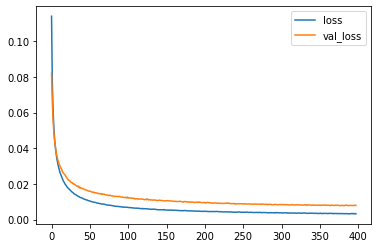

In [42]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [43]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(data = aPrediction, index = ixTest, columns = aIxOutputColumns)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(data = aActual, index = ixTest, columns = aIxOutputColumns).copy()

# RESULTS

In [44]:
iComparisionTimeStep = 0

In [45]:
y_pred = dfPrediction.iloc[:, iComparisionTimeStep]
y_true = dfActual.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.022
       mean squared error:                0.001
                max error:                0.128
                 r2 score:              -23.525


<AxesSubplot:xlabel='Actual', ylabel='Prediction'>

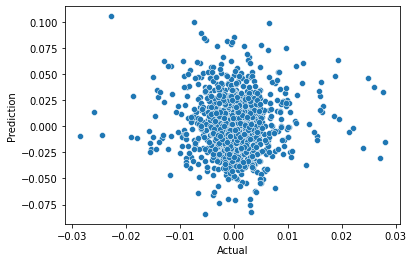

In [46]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActual.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

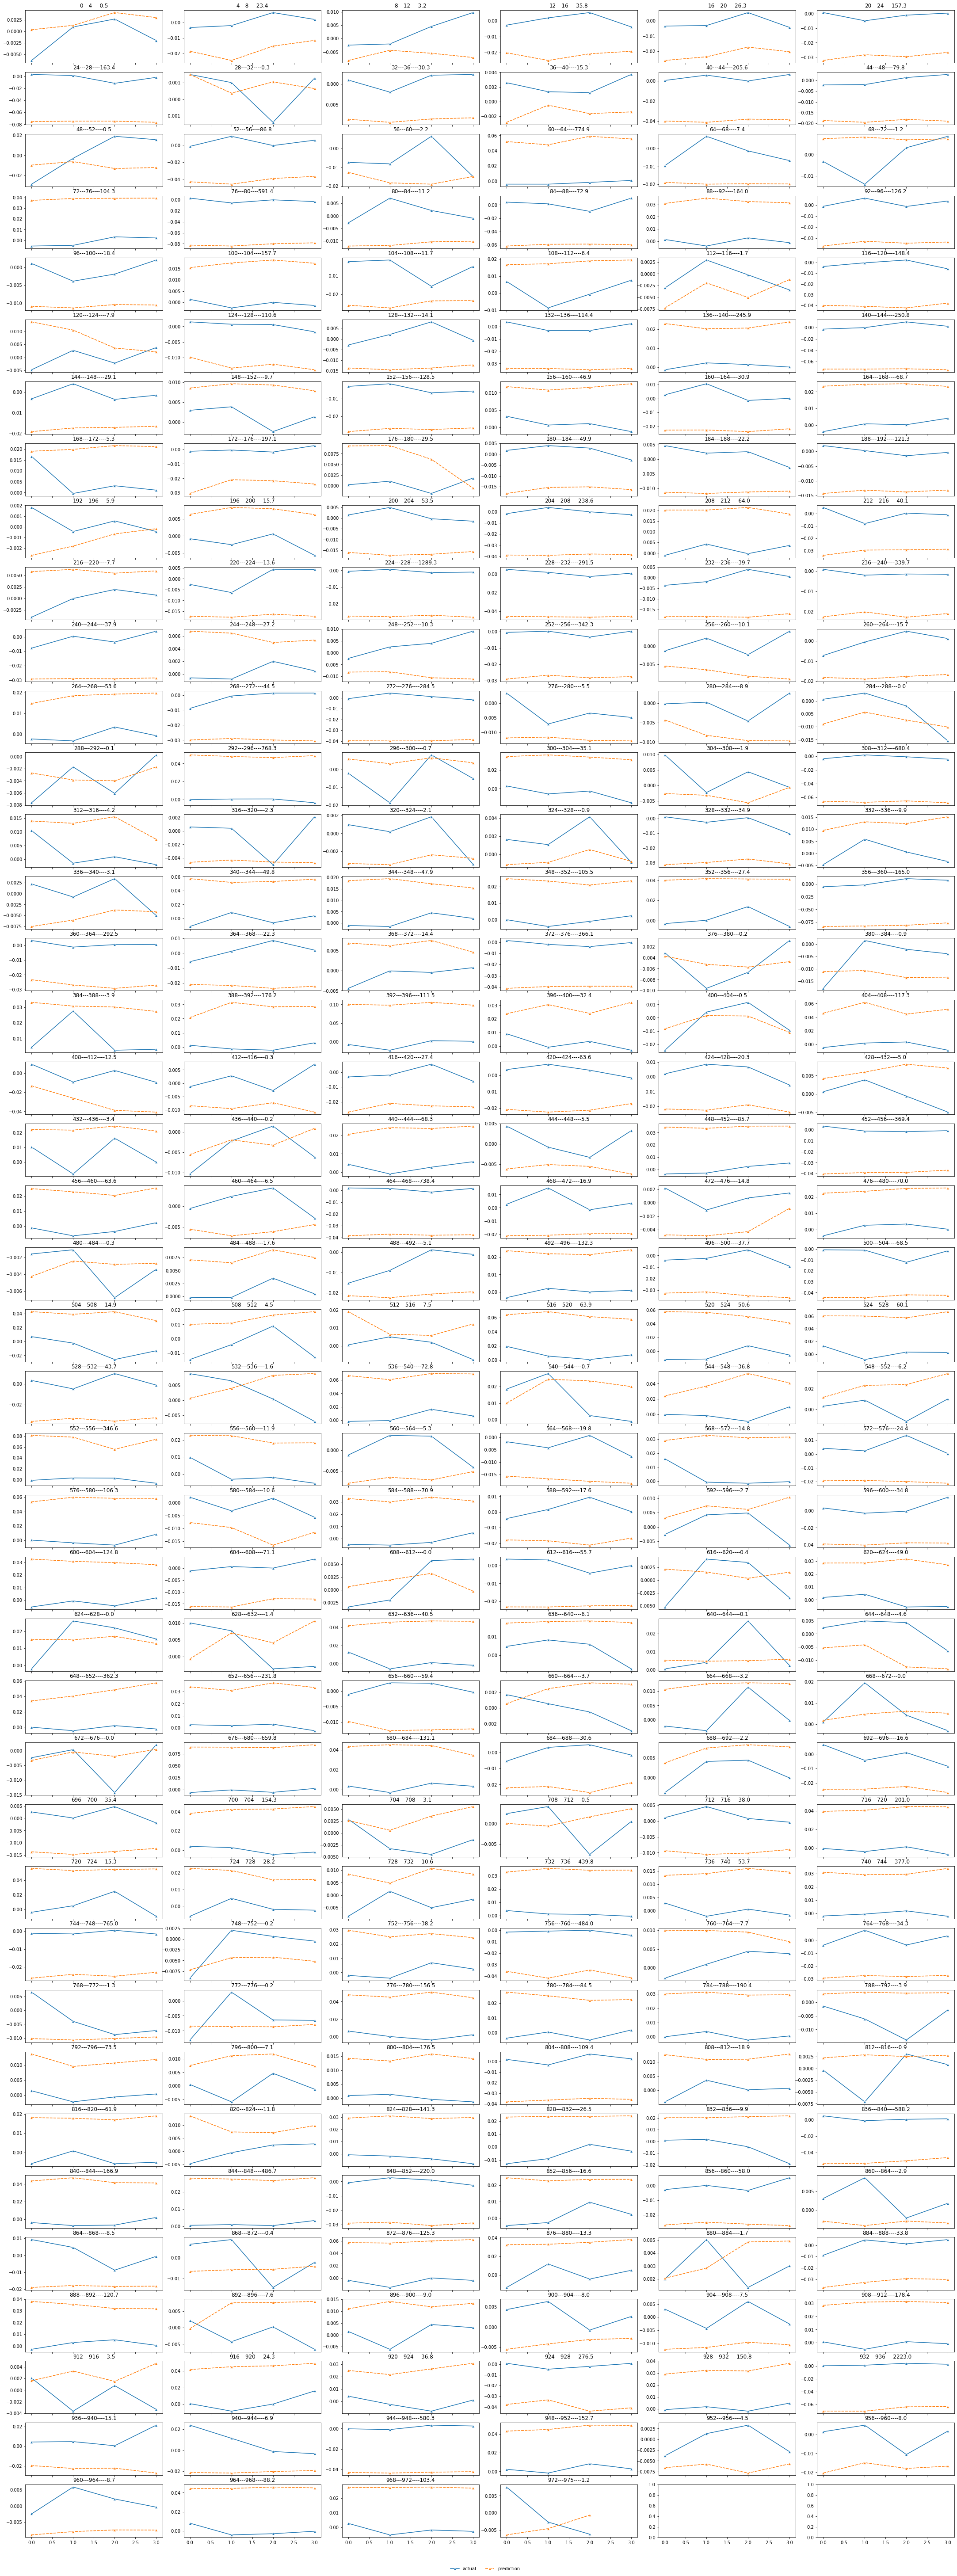

In [47]:
iNrOfCols = 6
iNrOfRows = int(((len(dfActual)/iNrOfCols)/iForwardTimeWindow) + 1)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(30,80), sharex = True)
oFig.tight_layout()
i = 0
for iSampleNr in range(0, len(dfActual), iForwardTimeWindow):
    iFrom = iSampleNr
    iTo = iFrom + iForwardTimeWindow

    if iTo >= len(dfActual):
        iTo = len(dfActual) 
    
    dfStepComparision = dfActual.iloc[iFrom:iTo].loc[:, (slice(None), slice(aOutputFeatures[0]))].loc[:, 0]
    dfStepComparision.columns = ["Actual"]

    dfStepComparision["Prediction"] = dfPrediction.iloc[iFrom].iloc[0:iTo-iFrom].loc[:, aOutputFeatures].values
    
    sTitleName = str(iFrom) + "---" + str(iTo) + "---" + str(round(r2_score(dfStepComparision["Actual"], dfStepComparision["Prediction"]),1))
    
    iSampleGraphRow =  int(i/iNrOfCols)
    iSampleGraphCol = int(i%iNrOfCols)
    
    dfStepComparision.reset_index(inplace = True)
    sns.lineplot(ax =aAxises[iSampleGraphRow,iSampleGraphCol] , data = dfStepComparision, legend = False,  marker = '^').set_title(sTitleName)
    
    i = i + 1

oFig.legend(aAxises[0][0].lines, ['actual', 'prediction'], frameon=False, loc='lower center', ncol=2,  bbox_to_anchor=(0.5,-0.01))  

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb